In [84]:
import os
from os import path
import glob
import re
from types import SimpleNamespace as simplenamespace

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
!ls ../benchmarks/ubuntu-xeon

fitsne-1.1.0  multicoretsne-0.1  opentsne-0.5.0  sklearn-0.23.1


In [15]:
BENCHMARK_DIR = "../benchmarks"

In [9]:
os.listdir(BENCHMARK_DIR)

['windows_i7', 'ubuntu-xeon']

## Define parsers

In [55]:
def make_regex_func(pattern):
    
    def _wrapper(fname):
        matches = [re.findall(pattern, line) for line in open(fname)]
        matches = list(filter(len, matches))
        matches = list(map(lambda x: float(x[0]), matches))

        return np.array(matches)
    
    return _wrapper

In [56]:
parse_opentsne = make_regex_func(r"openTSNE: Full (\d+\.\d+)")
parse_opentsne_nn = make_regex_func(r"openTSNE: NN search (\d+\.\d+)")
parse_opentsne_optimization = make_regex_func(r"openTSNE: Optimization (\d+\.\d+)")

opentsne = simplenamespace(full=parse_opentsne, nn=parse_opentsne_nn, optim=parse_opentsne_optimization)
    
print(opentsne.full("../benchmarks/ubuntu-xeon/opentsne-0.5.0/openTSNEFFT_8core_750000.log"))

[828.39280295 833.05999303 824.20338655 826.086061   827.24942827]


In [57]:
parse_fitsne = make_regex_func(r"FIt-SNE: (\d+\.\d+)")
parse_fitsne_nn = make_regex_func(r"100\% (\d+\.\d+)")

def parse_fitsne_optimization(n_points):
    full_times = parse_fitsne(n_points)
    nn_times = parse_fitsne_nn(n_points)
    return full_times - nn_times

fitsne = simplenamespace(full=parse_fitsne, nn=parse_fitsne_nn, optim=parse_fitsne_optimization)

print(fitsne.full("../benchmarks/ubuntu-xeon/fitsne-1.1.0/FItSNE_8core_750000.log"))

[931.35656977 926.1294198  925.61386228 932.54265189 924.50825572]


In [58]:
parse_multicore = make_regex_func(r"Multicore t-SNE: (\d+\.\d+)")
parse_multicore_nn = make_regex_func(r"Done in (\d+\.\d+) seconds")
parse_multicore_optimization = make_regex_func(r"Fitting performed in (\d+\.\d+) seconds")

multicore = simplenamespace(full=parse_multicore, nn=parse_multicore_nn, optim=parse_multicore_optimization)

print(multicore.full("../benchmarks/ubuntu-xeon/multicoretsne-0.1/MulticoreTSNE_8core_100000.log"))

[564.27792883 559.05652618 563.49405074 561.45723724 565.09974074]


In [59]:
parse_sklearn = make_regex_func(r"scikit-learn t-SNE: (\d+\.\d+)")
parse_sklearn_nn = make_regex_func(r"neighbors for .* samples in (\d+\.\d+)s")

def parse_sklearn_optimization(n_points):
    full_times = parse_sklearn(n_points)
    nn_times = parse_sklearn_nn(n_points)
    return full_times - nn_times

sklearn = simplenamespace(full=parse_sklearn, nn=parse_sklearn_nn, optim=parse_sklearn_optimization)

print(sklearn.full("../benchmarks/ubuntu-xeon/sklearn-0.23.1/sklearn_250000.log"))

[10467.07366467 10417.6181016  10595.89451599 10151.55403996
 10474.63974047]


In [60]:
parsers = {
    "openTSNEFFT": opentsne,
    "FItSNE": fitsne,
    "MulticoreTSNE": multicore,
    "sklearn": sklearn,
}

## Read data

In [104]:
files = list(glob.iglob(f"{BENCHMARK_DIR}/**/*.log", recursive=True))

data = []
for f in files:
    platform = f.split("/")[2]
    fname = path.basename(f)
    fname, ext = fname.split(".")
    split = fname.split("_")
    implementation, n_samples = split[:-1], int(split[-1])
    if len(implementation) == 2:
        implementation, cores = implementation
        cores = int(cores[0])
    else:
        implementation = implementation[0]
        cores = 1
    times = parsers[implementation].full(f)
    for t in times:
        data.append((platform, implementation, cores, n_samples, t))
        
data = pd.DataFrame(data, columns=["Platform", "Implementation", "Cores", "Num. Samples", "Time"])

In [105]:
data.head()

,Platform,Implementation,Cores,Num. Samples,Time
0,windows_i7,FItSNE,8,250000,291.648549
1,windows_i7,FItSNE,8,250000,293.345010
2,windows_i7,FItSNE,8,250000,302.002938
3,windows_i7,FItSNE,8,250000,294.060184
4,windows_i7,FItSNE,8,250000,305.779957


In [106]:
data.groupby(["Platform", "Implementation", "Cores", "Num. Samples"]).count().values.ravel()

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [156]:
data["Time (min)"] = data["Time"] / 60
data["Impl."] = data["Implementation"] + " (" + data["Cores"].astype(str) + " cores)"

In [138]:
data["Implementation"].unique()

array(['FItSNE', 'openTSNEFFT', 'sklearn', 'MulticoreTSNE'], dtype=object)

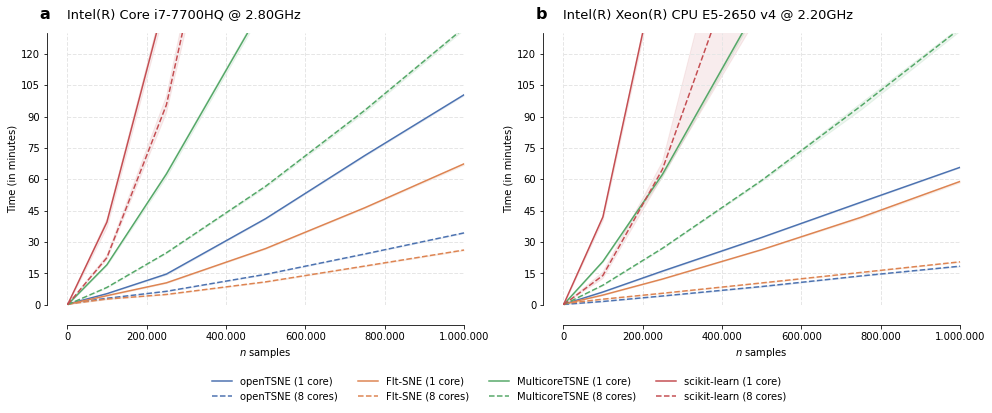

In [217]:
# import string

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
sns.despine(offset=20)
    
for letter, ax_ in zip(string.ascii_lowercase, ax):
    plt.text(-0.07, 1.051, letter, transform=ax_.transAxes, fontsize=16, fontweight="bold")

for title, ax_ in zip([
    "Intel(R) Core i7-7700HQ @ 2.80GHz",
    "Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz",
], ax):
    ax_.set_title(title, loc="Left", fontdict={"fontsize": "13"}, pad=15)
    
agg = data.groupby(["Platform", "Implementation", "Cores", "Num. Samples"])["Time (min)"].aggregate(["mean", "std"]).reset_index()

keys = [
    simplenamespace(impl="openTSNEFFT", cores=1, display="openTSNE (1 core)", color="#4C72B0", l="solid"),
    simplenamespace(impl="openTSNEFFT", cores=8, display="openTSNE (8 cores)", color="#4C72B0", l="dashed"),
    simplenamespace(impl="FItSNE", cores=1, display="FIt-SNE (1 core)", color="#DD8452", l="solid"),
    simplenamespace(impl="FItSNE", cores=8, display="FIt-SNE (8 cores)", color="#DD8452", l="dashed"),
    simplenamespace(impl="MulticoreTSNE", cores=1, display="MulticoreTSNE (1 core)", color="#55A868", l="solid"),
    simplenamespace(impl="MulticoreTSNE", cores=8, display="MulticoreTSNE (8 cores)", color="#55A868", l="dashed"),
    simplenamespace(impl="sklearn", cores=1, display="scikit-learn (1 core)", color="#C44E52", l="solid"),
    simplenamespace(impl="sklearn", cores=8, display="scikit-learn (8 cores)", color="#C44E52", l="dashed"),
]

## Plotting
for plat, ax_ in zip(["windows_i7", "ubuntu-xeon"], ax):
    ax_.set_xlabel("$n$ samples")
    ax_.set_ylabel("Time (in minutes)")

    ax_.grid(color="0.9", linestyle="--", linewidth=1)

    for t in keys:
        tmp = agg.query(f"Platform == '{plat}' & Implementation == '{t.impl}' & Cores == {t.cores}")
        ax_.plot(tmp["Num. Samples"], tmp["mean"], c=t.color, label=t.display, linestyle=t.l)
        ax_.fill_between(tmp["Num. Samples"],
                         tmp["mean"] + tmp["std"],
                         tmp["mean"] - tmp["std"], alpha=0.1, color=t.color)

    ax_.set_xlim(0, 1_000_000)
    ax_.set_ylim(0, 130)
    ax_.set_yticks(range(0, 130, 15))

    ax_.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(
        lambda x, p: format(int(x), ",").replace(",", ".")))
    
ax_.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05), bbox_transform=fig.transFigure, labelspacing=0.5, ncol=4)

plt.subplots_adjust(wspace=0.25)
plt.savefig("../figures/benchmarks.pdf", dpi=160, bbox_inches="tight")